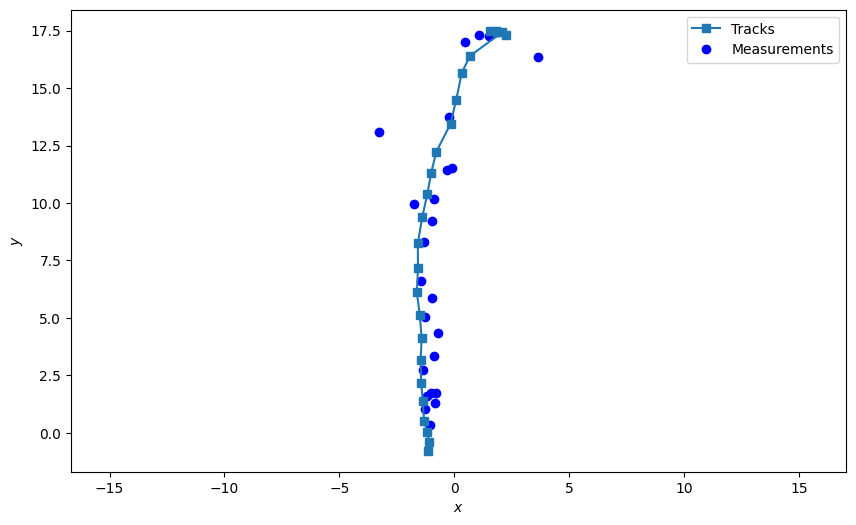

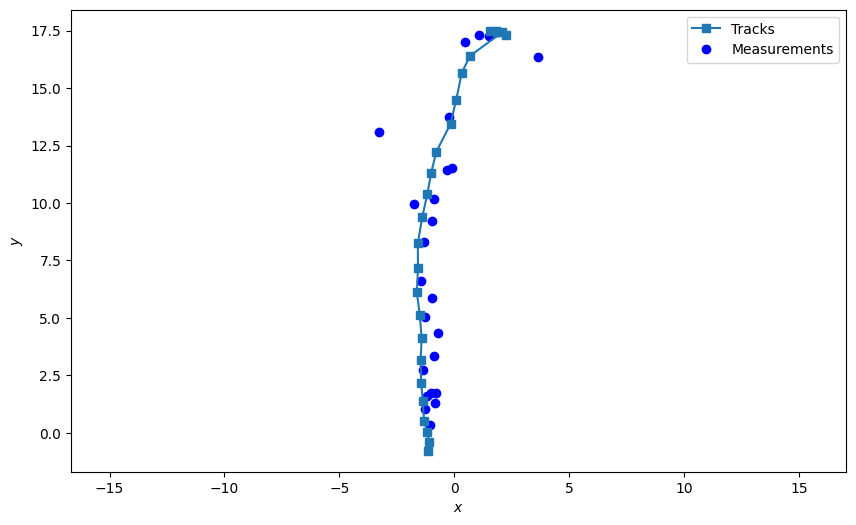

In [2]:
from numpy.random import randn
import math as m
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from itertools import count
from matplotlib import style
import time
import numpy as np
from stonesoup.predictor.kalman import KalmanPredictor
from stonesoup.updater.kalman import KalmanUpdater
from datetime import datetime, timedelta
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
                                               ConstantVelocity
from stonesoup.plotter import Plotter
from stonesoup.types.state import GaussianState
from stonesoup.types.track import Track
from stonesoup.types.hypothesis import SingleHypothesis

#variables 
var_bool = True 
PADT1 = []
mm = []
nn = []
cartesian_points=[]
cartesian_points_final=[]
pp = []
all_data = ""
cartesian_points=[]
temp_chaine= ""
temp_chaine2=""
x_coordinate = 0.0
y_coordinate = 0.0
xx = []
yy = []
current = 0 
plotter = Plotter()
track = Track()

# midpoint Algorithm

def midpoint(lst):
    if(len(lst)>1):
        #take distance between first two points as reference 
        distance_min = m.sqrt((lst[0][0]-lst[1][0])*(lst[0][0]-lst[1][0]) + (lst[0][1]-lst[1][1])*(lst[0][1]-lst[1][1]))
        point_1 = [lst[0][0],lst[0][1]]
        point_2 = [lst[1][0],lst[1][1]]
        for t in range(len(lst)-1):
            for s in range(t+1,len(lst)):
                distance = m.sqrt((lst[t][0]-lst[s][0])*(lst[t][0]-lst[s][0]) + (lst[t][1]-lst[s][1])*(lst[t][1]-lst[s][1]))
                if (distance<distance_min):
                    distance_min = distance
                    point_1 = [lst[t][0],lst[t][1]]
                    point_2 = [lst[s][0],lst[s][1]]
        midpoint_x = (point_1[0]+point_2[0])/2
        midpoint_y = (point_1[1]+point_2[1])/2
        l = [midpoint_x,midpoint_y]
        return [midpoint_x,midpoint_y]
                    
    else :
        l = [lst[0][0],lst[0][1]]
        return [lst[0][0],lst[0][1]]

    
    
    
# read and decode file 
file = open('2.txt','r')
read = file.readlines()
all_data = read[0]
all_points = all_data.split("/")
for x in range (0,len(all_points)-1):
        temp_chaine = all_points[x]
        PADT1 =temp_chaine.split("%")
        cartesian_points = []
        for v in range (0,len(PADT1)-1):
                    temp_chaine2 = PADT1[v]
                    z=  temp_chaine2.split(";")
                   # angle = (float(z[2])) *1.0*0.0174533
                    angle = m.radians(90-float(z[2]))
                    distance = float(z[0])/100
                    x_coordinate = (distance*(m.cos(angle)))    
                    y_coordinate = (distance*(m.sin(angle)))    
                  #  print(x_coordinate)
                  #  print(y_coordinate)
                  #  print("//////////////")
                    cartesian_points.append([x_coordinate,y_coordinate])
                    
        cartesian_points_final.append(cartesian_points)





l_truth = []
# Loop
for w in range(len(cartesian_points_final)):
        midpoint_list = midpoint(cartesian_points_final[w])
        #midpoint(cartesian_points_final[w])
        z = np.array(midpoint_list[0])
        e = np.array(midpoint_list[1])
        if((z!=0)or(e!=0)):
            l_truth.append([midpoint_list[0],midpoint_list[1]])
#print(l_truth)

    

# And the clock starts
start_time = datetime.now()

#transition model
np.random.seed(1991)
q_x = 0.35
q_y = 0.04
transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(q_x),ConstantVelocity(q_y)])
transition_model.matrix(time_interval=timedelta(seconds=1))
transition_model.covar(time_interval=timedelta(seconds=1))
from stonesoup.types.detection import Detection
from stonesoup.models.measurement.linear import LinearGaussian



# measurements process 
measurement_model = LinearGaussian(
    ndim_state=4,  # Number of state dimensions (position and velocity in 2D)
    mapping=(0, 2),  # Mapping measurement vector index to state index
    noise_covar=np.array([[1, 0],  # Covariance matrix for Gaussian PDF
                          [0, 1]])
    )
measurements = []
for i in range(len(l_truth)):
    #measurement = measurement_model.function(state, noise=True)
    measurements.append(Detection([l_truth[i][0],l_truth[i][1]],
                                  timestamp=start_time+timedelta(seconds=i*0.2),
                                  measurement_model=measurement_model))

    
#Kalman filter 
predictor = KalmanPredictor(transition_model)
updater = KalmanUpdater(measurement_model)
prior = GaussianState([[l_truth[0][0]], [1], [l_truth[0][1]], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)
for measurement in measurements:
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    hypothesis = SingleHypothesis(prediction, measurement)  # Group a prediction and measurement
    post = updater.update(hypothesis)
    #print(post)
    track.append(post)
    prior = track[-1]
plotter.plot_tracks(track, [0, 2], uncertainty=False)
#plotter.fig
plotter.plot_measurements(measurements, [0, 2])
plotter.fig
